## Setting up

#### Install packages:

In [280]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import PIL
import re

#### Set CSVs:

In [281]:
gp_csv = "/Users/GDEW/Dropbox/Jobs/GDS Associate DS/data_scientist_technical_exercise_data/GPPractices.csv"
indicators_csv = "/Users/GDEW/Dropbox/Jobs/GDS Associate DS/data_scientist_technical_exercise_data/TransparencyIndicatorsGPPerformance.csv"
hours_csv = "/Users/GDEW/Dropbox/Jobs/GDS Associate DS/data_scientist_technical_exercise_data/GPOpeningTimes.csv"

#### Read CSVs:

In [282]:
gp = pd.read_csv(gp_csv,
                 header=0,
                 sep="¬",
                 engine="python",
                 encoding='latin-1')
indicators = pd.read_csv(indicators_csv,
                        header=0,
                        sep="¬",
                        engine="python",
                        encoding='latin-1')
hours = pd.read_csv(hours_csv,
                        header=0,
                        sep="¬",
                        engine="python",
                        encoding='latin-1')

## Explore dataframes:

#### Function for exploring dataframes:
To help understand where data might need to be cleaned

In [283]:
def explorefunc(df):
    print("Dataframe shape")
    print(df.shape)
    print("Datatypes of each column")
    print(df.dtypes)
    print("Count of each column")
    print(df.count())
    print("Number of unique values for each column")
    print(df.nunique())
    print("Count of null values for each column")
    print(df.isnull().sum())
    return

In [284]:
explorefunc(gp)

Dataframe shape
(7580, 15)
Datatypes of each column
OrganisationID          int64
OrganisationCode       object
OrganisationType       object
SubType                object
OrganisationName       object
OrganisationStatus     object
IsPimsManaged            bool
Address1               object
Address2               object
Address3               object
City                   object
County                 object
Postcode               object
Latitude              float64
Longitude             float64
dtype: object
Count of each column
OrganisationID        7580
OrganisationCode      7580
OrganisationType      7580
SubType               7580
OrganisationName      7580
OrganisationStatus    7580
IsPimsManaged         7580
Address1              5420
Address2              3881
Address3              1955
City                  4898
County                3174
Postcode              5430
Latitude              5424
Longitude             5424
dtype: int64
Number of unique values for each column
Organ

In [285]:
explorefunc(indicators)

Dataframe shape
(428920, 6)
Datatypes of each column
OrganisationID       int64
OrganisationCode    object
OrganisationName    object
MetricName          object
Value               object
Text                object
dtype: object
Count of each column
OrganisationID      428920
OrganisationCode    428920
OrganisationName    428920
MetricName          428920
Value               397348
Text                428920
dtype: int64
Number of unique values for each column
OrganisationID      16447
OrganisationCode     9172
OrganisationName    10360
MetricName             17
Value                 730
Text                58144
dtype: int64
Count of null values for each column
OrganisationID          0
OrganisationCode        0
OrganisationName        0
MetricName              0
Value               31572
Text                    0
dtype: int64


In [286]:
explorefunc(hours)

Dataframe shape
(123744, 6)
Datatypes of each column
OrganisationId            int64
WeekDay                  object
Times                    object
IsOpen                     bool
OpeningTimeType          object
AdditionalOpeningDate    object
dtype: object
Count of each column
OrganisationId           123744
WeekDay                  122229
Times                    122393
IsOpen                   123744
OpeningTimeType          123744
AdditionalOpeningDate      1515
dtype: int64
Number of unique values for each column
OrganisationId           9026
WeekDay                     7
Times                    1436
IsOpen                      2
OpeningTimeType             3
AdditionalOpeningDate      74
dtype: int64
Count of null values for each column
OrganisationId                0
WeekDay                    1515
Times                      1351
IsOpen                        0
OpeningTimeType               0
AdditionalOpeningDate    122229
dtype: int64


## Cleaning datasets:

#### Drop indicators duplicates:

In [287]:
indicators = indicators.drop_duplicates().reset_index(drop=True)

#### Clean hours dataframe:
Note: these opening hours were not used in my analysis, but with more time I would use the opening hours interval to explore relationships with patient experience / satisfaction.

In [288]:
hours.rename(columns={'OrganisationId': 'OrganisationID'}, inplace=True)
hours['Open'], hours['Close'] = hours['Times'].str.split('-', 1).str
hours.drop(columns='Times')
hours = hours[['OrganisationID','WeekDay','Open','Close','OpeningTimeType','AdditionalOpeningDate']]
hours['Open'] = pd.to_datetime(hours['Open'], format='%H:%M').dt.time 
hours['Close'] = pd.to_datetime(hours['Close'], format='%H:%M').dt.time

#### Extract and convert percentages from Text column of indicators dataframe:
Required in order to sort and analyse these percentages as measures of GP confidence / opening hours satisfaction.

In [289]:
indicators['TextPercentages'] = indicators.Text.str.extract('(\d+\.[0-9]*)')
#convert to numeric value
indicators['TextPercentages'] = pd.to_numeric(indicators['TextPercentages'],errors='coerce')

#### Create list of headers for each dataframe:

In [290]:
gp_list = list(gp.columns.values)
indicators_list = list(indicators.columns.values)
hours_list = list(hours.columns.values)

#### Validate postcodes:

Note: this regex validation was not used in my analysis, but with more time, it could be used to identify erroneous postcodes, as well as postcodes erroneously entered in the wrong fields.

In [291]:
correct_postcodes = gp.City.str.contains("^[A-Z]{1,2}[0-9R][0-9A-Z]? [0-9][ABD-HJLNP-UW-Z]{2}$")

## Exploratoration of metrics

#### Identify which metrics are most populated with values:

In [292]:
count_metric = indicators.groupby('MetricName')['OrganisationID'].count().sort_values(ascending=False).reset_index(name='count')

In [293]:
count_metric

,MetricName,count
0,Flu vaccinations - Aged 65 and over group,15810
1,Flu vaccinations - Under 65 At Risk Groups,15808
2,Care Quality Commission Inspection Ratings,15772
3,Patient Satisfaction with GP Practice Opening ...,14225
4,Patient Experience - Confidence and Trust in GP,14225
5,Antibiotic Prescribing,14166
6,Cervical Cancer Screening,13973
7,Percentage of children aged 1 completed primar...,13925
8,"Proportion of children aged 2 with Measles, Mu...",13923
9,Proportion of children aged 2 with Haemophilu...,13923


#### Pivot indicators table:
For exploring the different values that each performance metric captures.

In [294]:
indicators_pivot = indicators.pivot(index='OrganisationID',columns='MetricName',values='Value')

In [295]:
indicators_pivot.sample(5)

MetricName,Antibiotic Prescribing,Cancer Detection Rate,Care Quality Commission Inspection Ratings,Cervical Cancer Screening,Dementia - Face to Face Reviews,Diabetes - Managing Blood Glucose Level (HbA1c),Flu vaccinations - Aged 65 and over group,Flu vaccinations - Under 65 At Risk Groups,High Blood Pressure Management,Mental Health  Comprehensive Care Planning,Patient Experience - Confidence and Trust in GP,Patient Satisfaction with GP Practice Opening Times,Percentage of children aged 1 completed primary course of 5:1 vaccine,Proportion of children aged 2 with Haemophilus influenzae type b and Meningitis C booster vaccine,"Proportion of children aged 2 with Measles, Mumps and Rubella vaccine",Proportion of children aged 2 with pneumococcal conjugate booster vaccine,Stroke prevention: medication for patients with atrial fibrillation
OrganisationID,,,,,,,,,,,,,,,,,
14692,0.98,70.40%,NaN,Below England expectation,Below England value,Above England value,Below England average,Below England average,Above England value,Above England value,Above England average,Similar to England average,Above England standard,Below England standard,Below England standard,Below England standard,Above England value
3557,1.08,43.30%,NaN,Below England expectation,Below England value,Above England value,Above England average,Below England average,Above England value,Above England value,Similar to England average,Below England average,Above England standard,Below England standard,Below England standard,Below England standard,Below England value
4185,NaN,NaN,NaN,NaN,NaN,NaN,Above England average,Below England average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55118,0.79,27.30%,NaN,Below England expectation,Above England value,Below England value,Below England average,Below England average,Below England value,Above England value,Below England average,Similar to England average,Below England standard,Below England standard,Below England standard,Below England standard,Below England value
3685,0.97,61.70%,NaN,Below England expectation,Below England value,Below England value,Above England average,Above England average,Above England value,Below England value,Similar to England average,Similar to England average,Below England standard,Above England standard,Below England standard,Below England standard,Above England value


#### Exploring values of individual metrics:

A sample of cancer detection rates. With more time, values such as these would be extracted and converted to be used for sorting and analysis. 

In [296]:
indicators[indicators['MetricName']=='Cancer Detection Rate'].sample(5)

,OrganisationID,OrganisationCode,OrganisationName,MetricName,Value,Text,TextPercentages
184977,51199,C82025,The Wycliffe Medical Practice,Cancer Detection Rate,46.90%,"64 detected by practice, out of new diagnoses.",NaN
221592,53853,F86028,Chadwell Heath Surgery,Cancer Detection Rate,64.70%,"17 detected by practice, out of new diagnoses.",NaN
437,3059,A81030,Borough Road & Nunthorpe Medical Group,Cancer Detection Rate,53.40%,"58 detected by practice, out of new diagnoses.",NaN
191947,51712,C82046,Saffron Group Practice,Cancer Detection Rate,50.00%,"48 detected by practice, out of new diagnoses.",NaN
226117,54199,E84667,Blessing Medical Centre,Cancer Detection Rate,83.30%,"6 detected by practice, out of new diagnoses.",NaN


A sample of CQC inspection ratings.

In [297]:
indicators[indicators['MetricName']=='Care Quality Commission Inspection Ratings'].sample(5)

,OrganisationID,OrganisationCode,OrganisationName,MetricName,Value,Text,TextPercentages
7752,3686,B81022001,Messingham Family Health Centre,Care Quality Commission Inspection Ratings,NaN,Good,NaN
26990,5445,C88038001,The Mathews Practice White Lane,Care Quality Commission Inspection Ratings,NaN,Inadequate,NaN
39999,11967,E85600,Willow Practice,Care Quality Commission Inspection Ratings,NaN,Good,NaN
150438,48759,P81004,Elizabeth Street Surgery,Care Quality Commission Inspection Ratings,NaN,Good,NaN
102332,17333,M91007,St John's Medical Centre,Care Quality Commission Inspection Ratings,NaN,Good,NaN


## Exploratory analysis of patient experience

#### Measuring patient experience: confidence and trust in GP

In [326]:
experience = indicators[indicators['MetricName']=='Patient Experience - Confidence and Trust in GP']

Drop duplicate entries:

In [327]:
experience = experience.drop_duplicates(subset = ['OrganisationCode','Text'])

Identify 5 worst practices for condifence and trust in GP:

In [328]:
experience.sort_values(by='TextPercentages').head()

,OrganisationID,OrganisationCode,OrganisationName,MetricName,Value,Text,TextPercentages
47798,12582,F82639,Dr Joseph,Patient Experience - Confidence and Trust in GP,Below England average,"58.65% had confidence, of 34 respondents.",58.65
101422,17261,M88041,Hawthorns Medical Centre,Patient Experience - Confidence and Trust in GP,Below England average,"63.40% had confidence, of 41 respondents.",63.40
74586,14983,J82199,Dr Lawson And Dr Alalade,Patient Experience - Confidence and Trust in GP,Below England average,"63.88% had confidence, of 207 respondents.",63.88
51264,12826,F84734,Boleyn Road Practice,Patient Experience - Confidence and Trust in GP,Below England average,"65.01% had confidence, of 94 respondents.",65.01
114473,24523,P82660,Deane Clinic One Stop Health Centre,Patient Experience - Confidence and Trust in GP,Below England average,"65.69% had confidence, of 46 respondents.",65.69


Creating a histogram to visualise confidence rates:

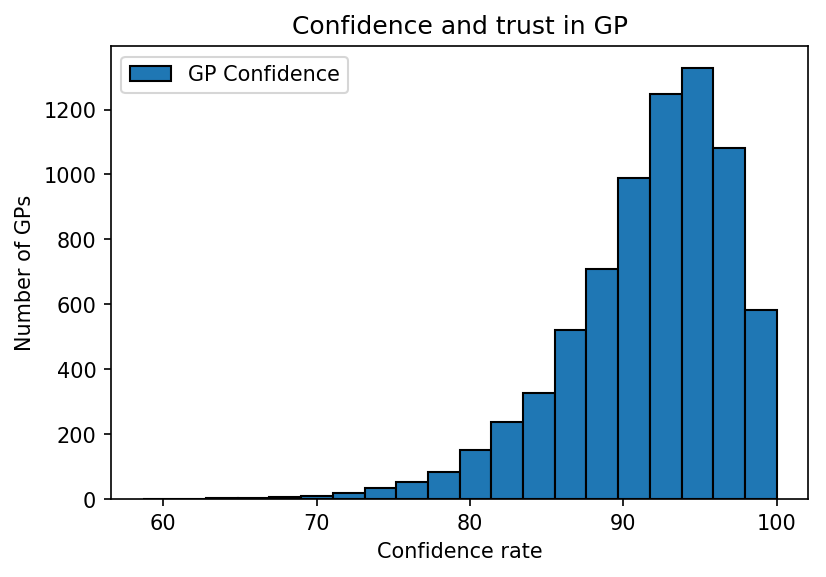

In [336]:
confidence_rate = experience['TextPercentages']
legend = ['GP Confidence']
plt.figure(dpi=(150))
plt.hist(confidence_rate, ec='black',bins=20)
plt.xlabel("Confidence rate")
plt.ylabel("Number of GPs")
plt.legend(legend)
plt.title('Confidence and trust in GP')
plt.show()

#### Measuring patient experience: satisfaction with GP opening times

In [329]:
times_satisfaction = indicators[indicators['MetricName']=='Patient Satisfaction with GP Practice Opening Times']

Drop duplicate entries:

In [330]:
times_satisfaction = times_satisfaction.drop_duplicates(subset = ['OrganisationCode','Text'])

Identify 5 worst practices for satisfaction with opening hours:

In [331]:
times_satisfaction.sort_values(by='TextPercentages').head()

,OrganisationID,OrganisationCode,OrganisationName,MetricName,Value,Text,TextPercentages
43355,12225,F81031,Dr M Aslam's Practice,Patient Satisfaction with GP Practice Opening ...,Below England average,"33.74% were satisfied, of 89 respondents.",33.74
2697,3252,A83014,Belmont & Sherburn Medical Group,Patient Satisfaction with GP Practice Opening ...,Below England average,"39.03% were satisfied, of 106 respondents.",39.03
40150,11976,E85633,The Southall Medical Centre,Patient Satisfaction with GP Practice Opening ...,Below England average,"41.23% were satisfied, of 103 respondents.",41.23
115055,24560,P84012,The Northenden Group Practice,Patient Satisfaction with GP Practice Opening ...,Below England average,"41.68% were satisfied, of 148 respondents.",41.68
241227,5480246,M91625,The Manor Practice,Patient Satisfaction with GP Practice Opening ...,Below England average,"41.69% were satisfied, of 38 respondents.",41.69


Creating a histogram to visualise satisfaction rates:

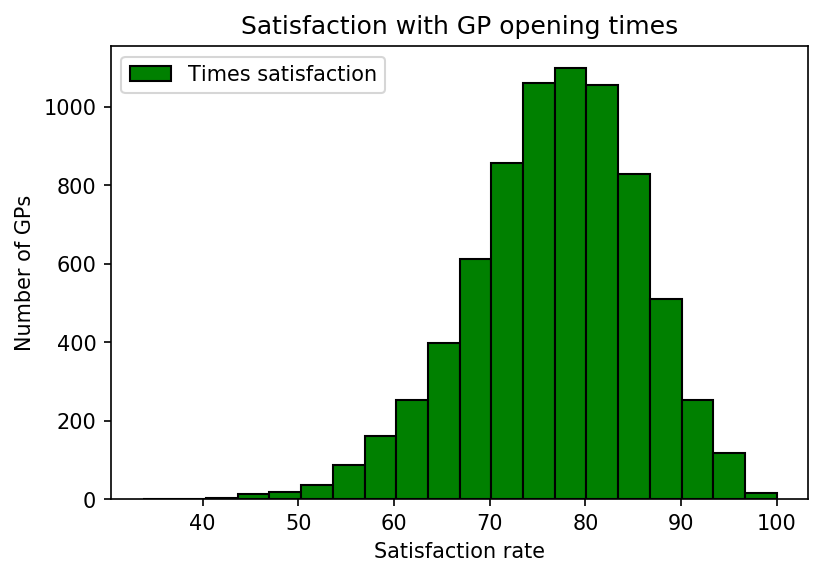

In [337]:
satisfaction_rate = times_satisfaction['TextPercentages']
legend = ['Times satisfaction']
plt.figure(dpi=(150))
plt.hist([satisfaction_rate], color=['green'],ec='black',bins=20)
plt.xlabel("Satisfaction rate")
plt.ylabel("Number of GPs")
plt.legend(legend)
plt.title('Satisfaction with GP opening times')
plt.show()

#### Measuring correlation between GP confidence and opening hours satisfaction:
Merge together dataframes:

In [311]:
satisfaction_merge = experience.merge(times_satisfaction,on=['OrganisationID','OrganisationCode','OrganisationName'])
satisfaction_merge.rename(columns={'TextPercentages_x': 'ConfidencePercent', 'TextPercentages_y': 'HoursSatisfyPercent'}, inplace=True)
satisfaction_merge.head()

,OrganisationID,OrganisationCode,OrganisationName,MetricName_x,Value_x,Text_x,ConfidencePercent,MetricName_y,Value_y,Text_y,HoursSatisfyPercent
0,2915,Y02622,Blackfriars Medical Practice,Patient Experience - Confidence and Trust in GP,Below England average,"78.52% had confidence, of 114 respondents.",78.52,Patient Satisfaction with GP Practice Opening ...,Similar to England average,"73.86% were satisfied, of 118 respondents.",73.86
1,3028,A81001,The Densham Surgery,Patient Experience - Confidence and Trust in GP,Below England average,"84.24% had confidence, of 60 respondents.",84.24,Patient Satisfaction with GP Practice Opening ...,Similar to England average,"66.36% were satisfied, of 59 respondents.",66.36
2,3029,A81002,Queens Park Medical Centre,Patient Experience - Confidence and Trust in GP,Similar to England average,"93.32% had confidence, of 292 respondents.",93.32,Patient Satisfaction with GP Practice Opening ...,Similar to England average,"71.56% were satisfied, of 279 respondents.",71.56
3,3031,A81004,Bluebell Medical Centre,Patient Experience - Confidence and Trust in GP,Similar to England average,"91.02% had confidence, of 130 respondents.",91.02,Patient Satisfaction with GP Practice Opening ...,Similar to England average,"71.52% were satisfied, of 131 respondents.",71.52
4,3033,A81005,Springwood Surgery,Patient Experience - Confidence and Trust in GP,Similar to England average,"93.99% had confidence, of 112 respondents.",93.99,Patient Satisfaction with GP Practice Opening ...,Similar to England average,"77.42% were satisfied, of 114 respondents.",77.42


Identify Pearson correlation between GP confidence and satisfaction with opening hours:

In [321]:
satisfaction_merge[['ConfidencePercent','HoursSatisfyPercent']].corr()

,ConfidencePercent,HoursSatisfyPercent
ConfidencePercent,1.000000,0.411029
HoursSatisfyPercent,0.411029,1.000000


Visualising this correlation:

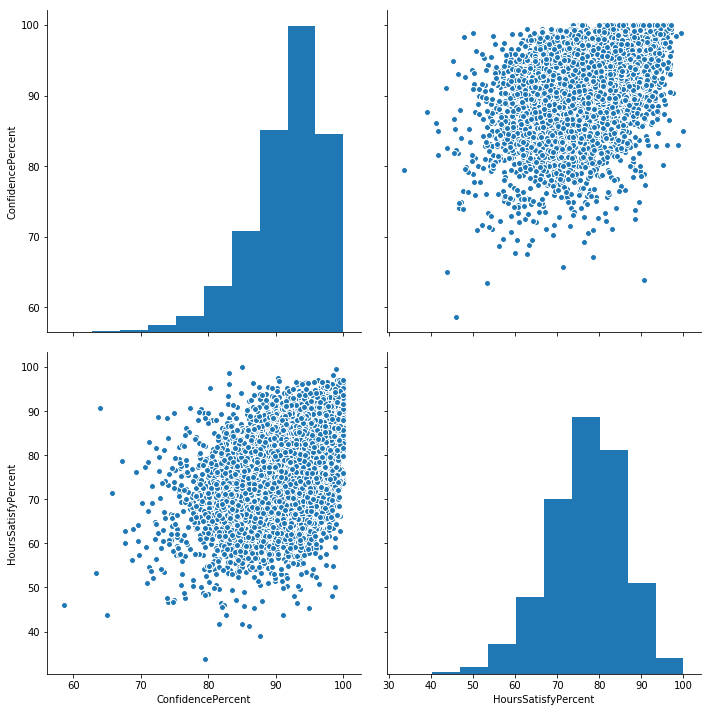

In [325]:
sns.pairplot(satisfaction_merge[['ConfidencePercent','HoursSatisfyPercent']],size=5)
plt.show()

## Mapping CQC ratings across the country

#### Create table that combines CQC ratings with longitude and latitude:
Filter CQC inspection ratings from indicators dataframe:

In [306]:
# Value column dropped as it is not required
ratings = indicators[indicators['MetricName']=='Care Quality Commission Inspection Ratings'].drop(columns='Value')

Extract latitude and longitude from GP info dataframe:

In [307]:
gplonglat = gp.dropna(subset=['Latitude','Longitude'])

Merge into one dataframe:

In [308]:
ratingsmerge = gplonglat.merge(ratings, on = ['OrganisationID','OrganisationCode','OrganisationName'], how = 'inner')

In [341]:
ratingsmerge.sample(5)

,OrganisationID,OrganisationCode,OrganisationType,SubType,OrganisationName,OrganisationStatus,IsPimsManaged,Address1,Address2,Address3,City,County,Postcode,Latitude,Longitude,MetricName,Text,TextPercentages
1462,49548,F82008,GP practice,UNKNOWN,Maylands Healthcare,Visible,False,300 Upper Rainham Road,NaN,NaN,Hornchurch,Essex,RM12 4EQ,51.552891,0.190568,Care Quality Commission Inspection Ratings,Good,NaN
3466,53084,K84036,GP practice,UNKNOWN,Mill Stream Surgery,Visible,False,Mill Stream,Benson,NaN,Walllingford,Oxfordshire,OX10 6RL,51.620586,-1.106145,Care Quality Commission Inspection Ratings,Outstanding,NaN
1623,49810,A83019,GP practice,UNKNOWN,Station Road Surgery,Visible,False,Station Road Surgery,Station Road,NaN,Shotton Colliery,Durham,DH6 2JL,54.764462,-1.395594,Care Quality Commission Inspection Ratings,Requires Improvement,NaN
1733,50034,J81621,GP practice,UNKNOWN,The Barcellos Family Practice,Visible,False,Corbin Avenue,Tricketts Cross,Ferndown,Dorset,NaN,BH22 8AZ,50.807991,-1.872232,Care Quality Commission Inspection Ratings,Good,NaN
1856,50187,H82043,GP practice,UNKNOWN,Grove House Surgery,Visible,False,80 Pryors Lane,NaN,NaN,Bognor Regis,West Sussex,PO21 4JB,50.781769,-0.718188,Care Quality Commission Inspection Ratings,Good,NaN


#### Create scatter plot of CQC ratings across England:

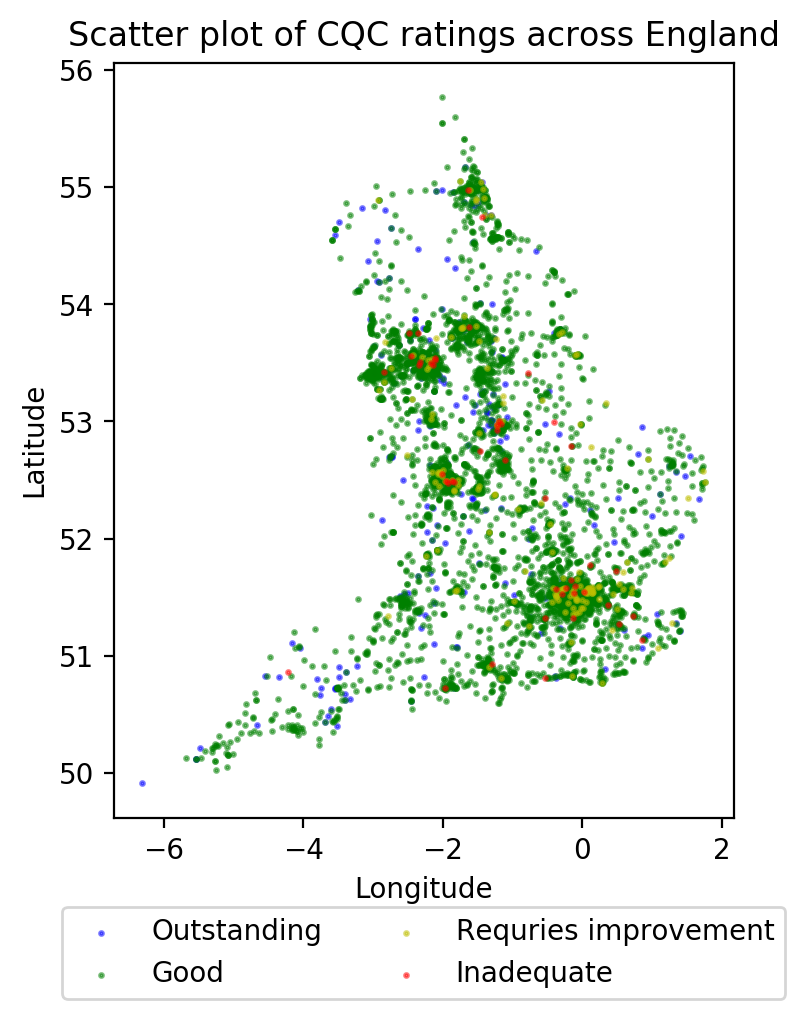

In [334]:
outstanding = ratingsmerge[ratingsmerge['Text']=='Outstanding']
good = ratingsmerge[ratingsmerge['Text']=='Good']
improve = ratingsmerge[ratingsmerge['Text']=='Requires Improvement']
inadequate = ratingsmerge[ratingsmerge['Text']=='Inadequate']
fontP = FontProperties()
fontP.set_size('small')

plt.figure(dpi=(200),figsize=(4,5))
plt.scatter('Longitude','Latitude',data=outstanding,color='b',s=2, alpha=0.5,label="Outstanding")
plt.scatter('Longitude','Latitude',data=good,color='g',s=2, alpha=0.5,label="Good")
plt.scatter('Longitude','Latitude',data=improve,color='y',s=2, alpha=0.5,label="Requries improvement")
plt.scatter('Longitude','Latitude',data=inadequate,color='r',s=2, alpha=0.5,label="Inadequate")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter plot of CQC ratings across England')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()